In [1]:
%autosave 0

import inspect

import arviz as az
import nest_asyncio
import pandas as pd
from IPython.display import display, display_markdown

import linear_regression as lin

data = pd.read_csv('heart.csv')
samples = data[data.columns.difference(['target'])]
outcomes = data['target']


Autosave disabled


## Linear regression

### Model description

The multivariable linear regression model describes the relation of given parameters to the probability of detecting disease.

\begin{align}
    \theta_i = \alpha_1 + \beta_1x_{1i} + \alpha_2 + \beta_2x_{2i} + ... + \alpha_J + \beta_Jx_{Ji}
\end{align}

where
- $\theta_i$ is the probability of detecting disease
- $\alpha_.$ and $\beta_.$ is the intercept and scalar response parameters of $\beta{x}+\alpha$
- $J$ is the number of studied variables or number of dimensions from given data

Stan model embeds the necessary data normalization and linearly scales $x_.$ to range $[0;1]$.

Spliting $\alpha$ into $J$ parts is rather unconventional, but it allows to better visualise correlation for each parameter of interest separately.

Thus, it gives a set of separate $kx + b$ -like equations that are easy to visualise and validate based on expert knowledge.

See the related Stan model source code in [Appendix A](#Appendix-A).


In [21]:
%%capture --no-display

nest_asyncio.apply()
model = lin.build(samples, outcomes)
fit = lin.sample(model)

Below is the visualisation of the linear correlation of disease probability and parameter values shown in red lines. Blue spots show the distribution of given data, jittered along the x-axis to improve readability. y-axis illustrates the estimated probability of disease.

The linear correlation has an exaggerated slope in comparison with the data points, because it shows the isolated parameter correlation with the disease, whereas draws are given from real data and obey many opposing factors.


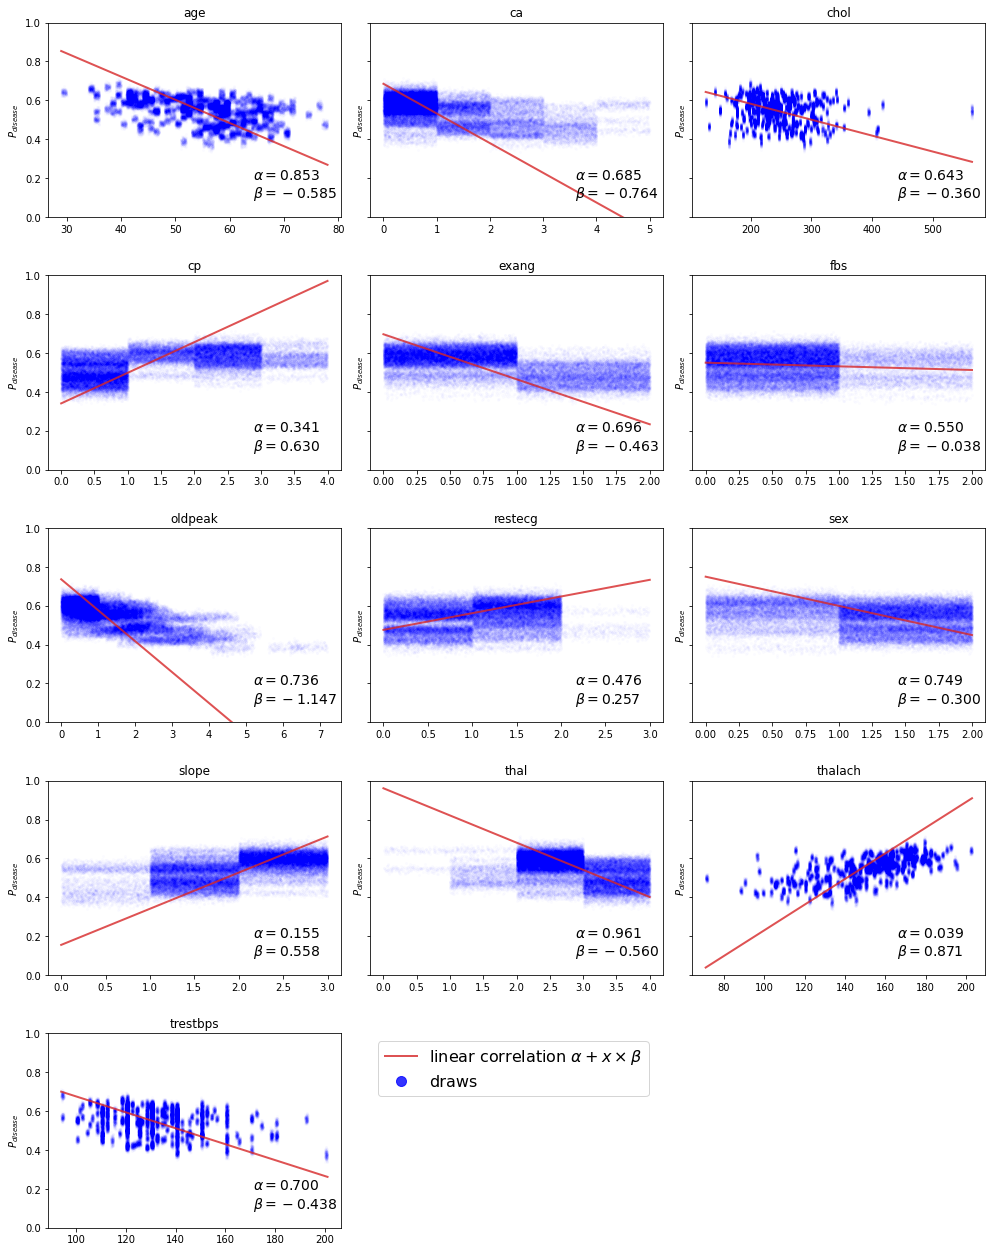

In [23]:
lin.plot_draws(fit, samples)


### Convergence diagnostics

In [22]:
display(az.summary(fit, round_to=3, hdi_prob=0.9, var_names=['alpha', 'beta', 'sigma']))

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.853,0.075,0.723,0.970,0.002,0.001,1259.776,542.297,1.001
alpha[1],0.685,0.032,0.631,0.735,0.001,0.000,2496.112,1480.662,1.000
alpha[2],0.643,0.069,0.519,0.747,0.002,0.001,1588.807,1163.269,1.000
alpha[3],0.341,0.038,0.284,0.408,0.001,0.001,2036.458,1629.479,1.002
alpha[4],0.696,0.033,0.636,0.746,0.001,0.000,2701.244,1489.118,1.006
alpha[5],0.550,0.031,0.501,0.604,0.001,0.000,2989.441,1288.278,1.000
alpha[6],0.736,0.036,0.676,0.795,0.001,0.000,2693.962,1570.676,1.000
alpha[7],0.476,0.039,0.413,0.538,0.001,0.001,2220.427,1500.023,1.000
alpha[8],0.749,0.048,0.670,0.832,0.001,0.001,2094.155,1367.282,1.003
alpha[9],0.155,0.066,0.046,0.261,0.001,0.001,1772.778,1173.613,1.005



Based on `r_hat` values, all chains have successfully converged for all estimated variables. None of them exceeds the set threshold value $1.01$.

TODO: interpret ess, n_eff, tree depth and divergences

### Loo

```python
def psis_loo_summary(fit: Fit):
    loo = az.loo(fit, pointwise=True)
    display(loo)
    fig, ax = plt.subplots(figsize=(8, 3))
    az.plot_khat(loo, show_bins=True, ax=ax)
    ax.set_title('Loo Linear model')
    print(f"Mean Pareto K: {loo['pareto_k'].values.mean():.2f}")
    plt.show()

```

Computed from 2000 by 3939 log-likelihood matrix

         Estimate       SE
elpd_loo -1012844.31  3511.56
p_loo    125917.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       44    1.1%
 (0.5, 0.7]   (ok)         69    1.8%
   (0.7, 1]   (bad)       385    9.8%
   (1, Inf)   (very bad) 3441   87.4%

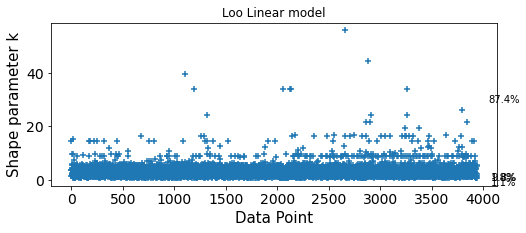

In [24]:
%%capture --no-display

lin.psis_loo_summary(fit)

As can be seen above, the PSIS-LOO doesn't provide reliable estimate due to a large number of Pareto-K values higher than 1 (mean K value is about 3 times higher). Due to that fact and thanks to relatively low number of data points we can run full leave-one-out validation without folding to get more reliable predictive accuracy estimates and provide some intuition about actual predictive accuracy.

The source code of `loo_cv` function can be found in  [Appendix B](#Appendix-B).

⚠️ Running full LOO takes about 1 hour on a laptop with Intel Core i7-8569U CPU @ 2.80GHz.

In [13]:
lin.loo_cv(samples, outcomes)

LOO score: 78.55% | Predicted: 238 / 303 | False positives: 58 | False negatives: 7

```
LOO-CV score: 78.55% | Predicted: 238 / 303 | False positives: 58 | False negatives: 7
```

As can be seen, the linear model is not able to properly describe the data and give reliable estimates. It has low predictive accuracy a bit less than 80% and produces especially high number of false positives diagnoses.

Moreover, most of the false positive predictions had very high confidence level, so true negative result was beyond the 90% confidence range.

One way of improving the model could be changing its sensitivity threshold, but in best case scenario it improved the model accuracy to 82.84%, which is still far from perfect and doesn't fix severe false positive predictions' error.

Hence, the linear regression is not recommended to use in real applications, but it can reveal basic insights on the underlying correlations. The next chapter consider the logarithmic regression model which is expected to show better results.

TODO: Background knowledge check if the model make sense


### Prior sensitivity

For the prior sensitivity analysis we will use a bit more simple and much quicker version of leave-one-out validation and check within-sample predictive accuracy. This summary is quick and easy to understand but is in general an overestimate of LOO-CV because it is evaluated on the data from which the model was fit.

The PSIS-LOO values are also included in the analysis to build more solid connection between posterior log likelihood values and predictive accuracy.

For the `loo_within_sample` implementation see [Appendix D](#Appendix-D).


TODO: Sensitivity analysis with respect to prior choices (create sensitivity table)

### Appendix A

**Stan code for linear regression model**

In [4]:
with open('linear_regression.stan', 'r') as file:
    display_markdown(f"```cpp\n{file.read()}\n```", raw=True)


```cpp
data {
  int<lower=1> N;                           // number of data points
  int<lower=1> J;                           // number of dimensions
  matrix[N, J] x;                           // data
  real<lower=0, upper=1> y[N];              // outcomes
  real prior_alpha_mu;                      // prior mean for alpha
  real<lower=0> prior_alpha_sigma;          // prior std for alpha
  real prior_beta_mu;                       // prior mean for beta
  real<lower=0> prior_beta_sigma;           // prior std for beta
}
transformed data {
  vector[J] min_x;
  vector[J] scale_x;
  matrix<lower=0, upper=1>[N, J] x_std;
  for (j in 1:J) {
    min_x[j] = min(x[,j]);
    scale_x[j] = (max(x[,j]) - min_x[j]);
    x_std[,j] = (x[,j] - min_x[j]) / scale_x[j];
  }
}
parameters {
  vector<lower=0, upper=1>[J] alpha;
  vector[J] beta;
  real<lower=0> sigma;
}

model {
  sigma ~ cauchy(0,10);
  for (j in 1:J) {
    alpha[j] ~ beta(1, 1);
    beta[j] ~ normal(prior_beta_mu, prior_beta_sigma);
    y ~ normal(alpha[j] + beta[j] * x_std[,j], sigma);
  }
}
generated quantities {
  vector[N * J] log_lik;
  vector<lower=0, upper=1>[N] probs = rep_vector(0, N);

  for (i in 1:N) {
    for (j in 1:J) {
      log_lik[(i - 1) * J + j] = normal_lpdf(y | alpha[j] + beta[j] * x_std[i,j], sigma);
      probs[i] += alpha[j] + beta[j] * x_std[i,j];
    }
    probs[i] /= J;
  }
}

```

### Appendix B

**Leave-one-out cross-validation**

This function implements the full LOO-CV validation by fitting the model with i-th sample excluded from the data. Then estimated disease probability is compared with actual `target` value for the given sample.

In [3]:
display_markdown(f"```python\n{inspect.getsource(lin.get_prob)}\n```", raw=True)
display_markdown(f"```python\n{inspect.getsource(lin.loo_cv)}\n```", raw=True)

```python
def get_prob(fit, data: pd.DataFrame, sample):
    prob = np.zeros(fit.num_chains * fit.num_samples)
    scale = (data.max() - data.min())
    sample_std = (sample - data.min()) / scale
    for i, param_name in enumerate(data.columns):
        alpha_i = fit['alpha'][i]
        beta_i = fit['beta'][i]
        x_i = sample_std[param_name].iloc[0]
        prob += alpha_i + beta_i * x_i

    prob /= sample.shape[1]
    return prob

```

```python
def loo_cv(samples: pd.DataFrame, outcomes: pd.DataFrame):
    num = samples.shape[0]
    false_pos, false_neg, predicted = 0, 0, 0
    start_time = time.time()
    for i in range(num):
        sample_query = samples.index.isin([i])
        test_sample = samples[sample_query]
        outcome_query = outcomes.index.isin([i])
        test_outcome = outcomes[outcome_query].values[0]

        with suppress_stdout_stderr():
            loo_outcomes = outcomes[~outcome_query]
            loo_samples = samples[~sample_query]
            model = build(loo_samples, loo_outcomes)
            fit = model.sample(num_chains=4, num_samples=200, num_warmup=200)

        prob_mean = get_prob(fit, samples, test_sample).mean()
        false_pos += not test_outcome and (prob_mean >= .5)
        false_neg += test_outcome and (prob_mean < .5)
        predicted += test_outcome == (prob_mean >= .5)
        eta = datetime.fromtimestamp(time.time() + (time.time() - start_time) / (i + 1) * num)
        print(f'ETA: {eta.strftime("%H:%M:%S")}', end=' | ')
        print(f"LOO-CV score: {predicted / (i + 1) * 100:3.2f}%", end=' | ')
        print(f"Predicted: {predicted:3d} / {i + 1:3d}", end=' | ')
        print(f"False positives: {false_pos} | False negatives: {false_neg}", end='\r', flush=True)

    print(f"\nTotal time: {time.time() - start_time}")

```

### Appendix D

**Leave-one-out within-sample predictive accuracy**

This function relies on `probs` values computed by Stan model's `generated quantities` block.

In [2]:
display_markdown(f"```python\n{inspect.getsource(lin.loo_within_sample)}\n```", raw=True)

```python
def loo_within_sample(fit: Fit, outcomes: pd.DataFrame):
    false_pos, false_neg, predicted = 0, 0, 0
    for i, actual_outcome in enumerate(outcomes):
        prediction = fit['probs'][i].mean() >= .5
        false_pos += not actual_outcome and prediction
        false_neg += actual_outcome and not prediction
        predicted += actual_outcome == prediction
    print(f"LOO-WS score: {predicted / len(outcomes) * 100:3.2f}%", end=' | ')
    print(f"Predicted: {predicted:3d} / {len(outcomes):3d}", end=' | ')
    print(f"False positives: {false_pos} | False negatives: {false_neg}")

```